In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from symbolic_pofk.pk_to_hmf import full_pipeline_hmf  
import joblib
import matplotlib.pyplot as plt



### Cleaning Traningset 


In [2]:
df = pd.read_csv("../symbolic_pofk/HMF_dataset_with_baryons_2000cp.csv")
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()



In [3]:

df.describe()

,Cosmo_ID,As,Om,Ob,h,ns,w0,wa,A_SN1,A_SN2,A_AGN1,A_AGN2,sigma8,Mass,Z,Sigma,HMF
count,890800.000000,890800.000000,890800.000000,890800.000000,890800.000000,890800.000000,890800.000000,890800.000000,890800.000000,890800.000000,890800.000000,890800.000000,890800.000000,8.908000e+05,890800.000000,890800.000000,8.908000e+05
mean,1002.933588,2.997795,0.325516,0.048817,0.750051,0.980104,-1.000837,0.001522,2.517083,2.493464,2.490585,2.496246,1.049514,6.370423e+14,2.502878,1.094479,2.178993e-02
std,578.598112,0.287774,0.159337,0.028321,0.143849,0.034570,0.173508,0.288493,1.442527,1.444682,1.441850,1.442954,0.518774,1.166312e+15,1.567762,0.953287,7.669338e-02
min,0.000000,2.500749,0.010278,0.001039,0.500208,0.920011,-1.299989,-0.499819,0.000664,0.001042,0.001243,0.000886,0.034187,1.000000e+12,0.000000,0.010337,0.000000e+00
25%,500.000000,2.749316,0.189637,0.024257,0.626348,0.950140,-1.152162,-0.246426,1.268036,1.239316,1.252022,1.251903,0.661855,8.445258e+12,1.363636,0.443271,9.293215e-07
50%,1004.000000,2.995546,0.326458,0.048173,0.749789,0.979947,-1.000718,0.003415,2.527188,2.483837,2.490276,2.499717,1.025127,7.113266e+13,2.727273,0.824915,2.584520e-04
75%,1505.000000,3.245664,0.463405,0.072785,0.874472,1.010158,-0.850201,0.249004,3.763347,3.745299,3.741275,3.744908,1.420402,5.973638e+14,4.090909,1.454145,5.979697e-03
max,1999.000000,3.499598,0.599882,0.099912,0.999910,1.039984,-0.700121,0.499799,4.998350,4.999440,4.998830,4.998375,2.594647,5.000000e+15,5.000000,10.299601,1.287595e+00


In [4]:
# df["Mass"] = np.log10(df["Mass"])

array([[<Axes: title={'center': 'Cosmo_ID'}>,
        <Axes: title={'center': 'As'}>, <Axes: title={'center': 'Om'}>,
        <Axes: title={'center': 'Ob'}>],
       [<Axes: title={'center': 'h'}>, <Axes: title={'center': 'ns'}>,
        <Axes: title={'center': 'w0'}>, <Axes: title={'center': 'wa'}>],
       [<Axes: title={'center': 'A_SN1'}>,
        <Axes: title={'center': 'A_SN2'}>,
        <Axes: title={'center': 'A_AGN1'}>,
        <Axes: title={'center': 'A_AGN2'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'Mass'}>, <Axes: title={'center': 'Z'}>,
        <Axes: title={'center': 'Sigma'}>],
       [<Axes: title={'center': 'HMF'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

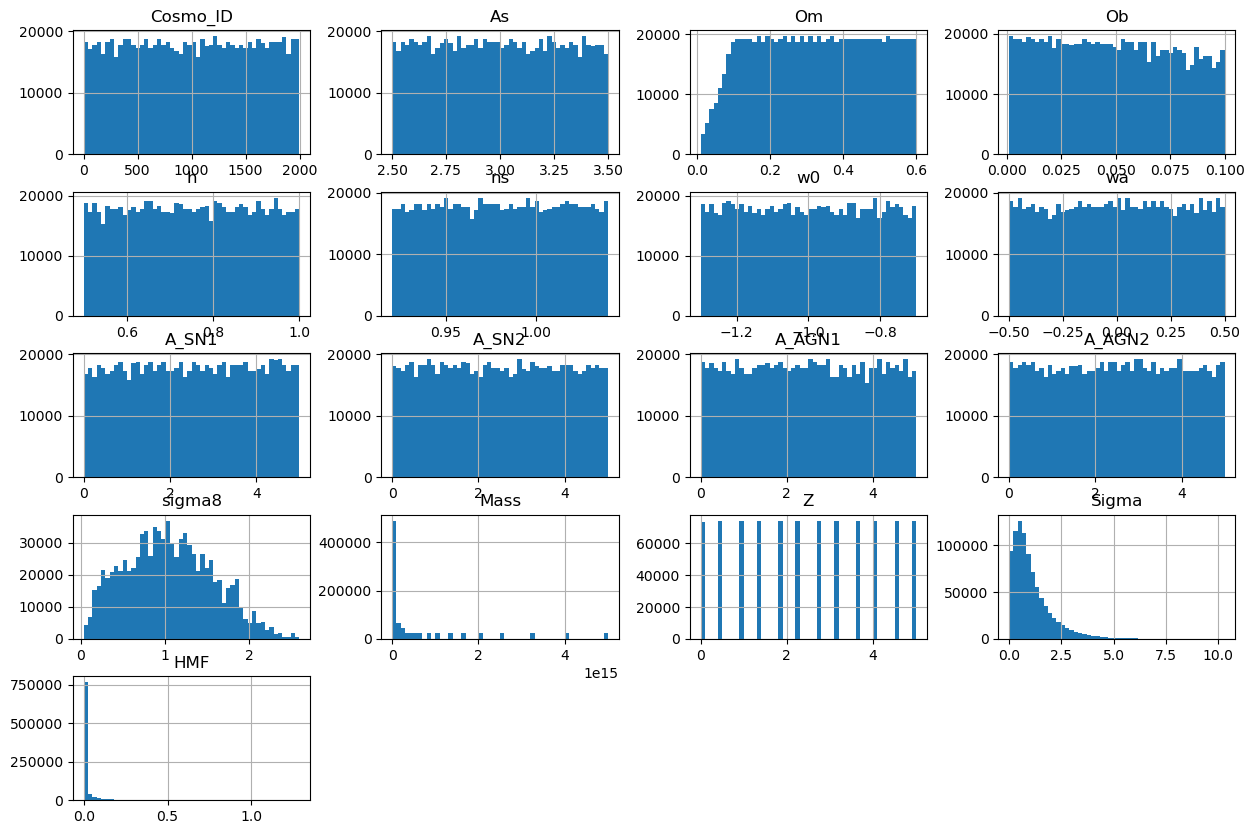

In [5]:
df.hist(bins=50, figsize=(15, 10))

In [6]:
# df["Sigma8_test"] = df["sigma8"].copy()
# df = df[df["Sigma8_test"] > 0.8]
# df = df[df["Sigma8_test"] < 1.1]


In [7]:
print((df["HMF"] < 1e-300).sum())

14414


In [45]:
(df["HMF"] < 1e-320).sum()

13578

### LightGBM

In [8]:
import lightgbm as lgb

X = df[["As","ns","Om","Ob","h", "w0","wa","A_SN1","A_SN2","A_AGN1","A_AGN2","Z"]]
X["logMass"] = np.log10(df["Mass"])

C:\Users\MAIYP\AppData\Local\Temp\ipykernel_90676\2889473168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["logMass"] = np.log10(df["Mass"])


In [13]:
len((X.columns).tolist())

13

### Neural Network 2108

#### Manipulation Data (HMF, Mass)

In [13]:
from sklearn.preprocessing import StandardScaler
X = df[["As","Om","Ob","h","ns","w0","wa","A_SN1","A_SN2","A_AGN1","A_AGN2","Mass","Z"]].copy()
y = df["HMF"].copy()

# --- Transform Mass ---
X["Mass"] = np.log10(X["Mass"]) 

# --- Transform HMF ---
eps = 1e-320  # Avoid log(0)
y_log = np.log10(y + eps)

# --- Scaling ---
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_log.values.reshape(-1,1))

#### Create Model (Keras)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

n_features = X_scaled.shape[1] 

model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # output regression
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',       # Mean Squared Error for regression
    metrics=['mae']   # Mean Absolute Error for following
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,801 (175.00 KB)

 Trainable params: 44,801 (175.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Train Model 


##### Split Data (Train 80%, Test 10%, Validation 10%)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


##### Train Model 

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=1024,       #big dataset -> big batch too
    verbose=1
)

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0913 - mae: 0.1708 - val_loss: 0.0182 - val_mae: 0.0794
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - mae: 0.0664 - val_loss: 0.0094 - val_mae: 0.0582
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mae: 0.0490 - val_loss: 0.0065 - val_mae: 0.0460
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - mae: 0.0418 - val_loss: 0.0038 - val_mae: 0.0360
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0033 - val_mae: 0.0334
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - mae: 0.0330 - val_loss: 0.0024 - val_mae: 0.0294
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - mae: 0.0309 - val_loss: 0.0022 - val_mae: 0.0302
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mae: 0.0270 - val_loss: 0.0023 - val_mae: 0.0284
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

##### Evaluate on "Test set"

In [17]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")


Test Loss (MSE): 0.0002
Test MAE: 0.0110


##### predict and inverse transform

In [18]:
# Predict on test
y_pred_scaled = model.predict(X_test)

# Inverse scaling
y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
y_true_log = scaler_y.inverse_transform(y_test)

# Transform to HMF real
eps = 1e-320
y_pred = np.power(10, y_pred_log) - eps
y_true = np.power(10, y_true_log) - eps


582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step


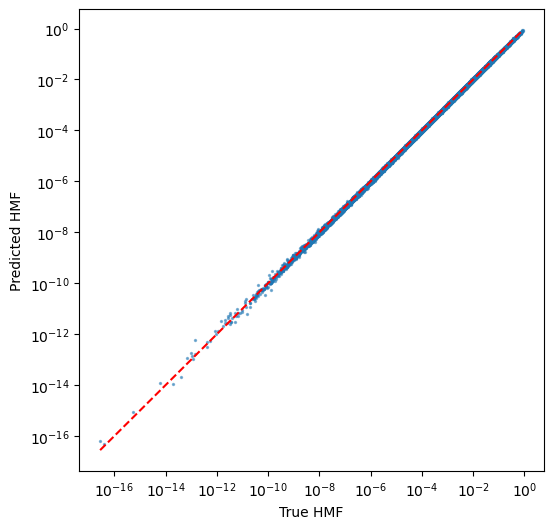

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=2, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True HMF")
plt.ylabel("Predicted HMF")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [20]:
model.save("hmf_model.keras")
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

['scaler_y.pkl']

c:\Users\MAIYP\anaconda3\envs\CosmoCNRS\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Relative error: median = 0.14010127258815736 , p90 = 0.714359901212404
Log10 error (dex): median = 0.058265873018822134 , p90 = 0.544262354635977 => median multiplicative factor ~ 1.1435782136868036


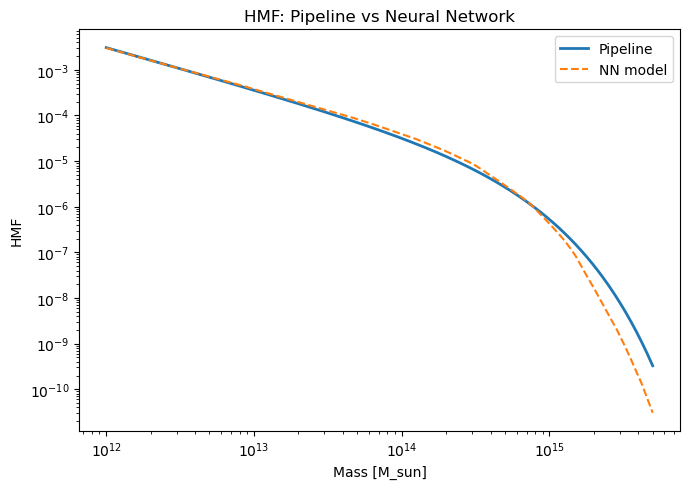

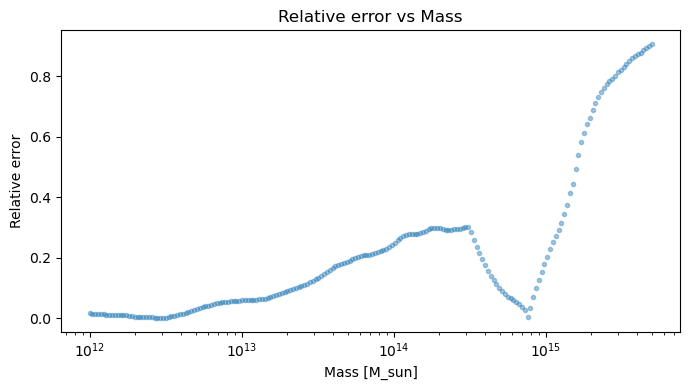

In [21]:
# compare_model_vs_pipeline.py
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ---- 1) import pipeline
from symbolic_pofk.pk_to_hmf import full_pipeline_hmf

# ---- 2) Mass range: 1e12 -> 5e15
M_vals = np.logspace(12, np.log10(5e15), 200) 

# eps & tiny
EPS  = 1e-20
TINY = 1e-20

# ---- 3) Lim Param
PARAM_BOUNDS = {
    "As":   (2.5, 3.5),
    "Om":   (0.0, 0.6),
    "Ob":   (0.0, 0.10),
    "h":    (0.5, 1.0),
    "ns":   (0.90, 1.00),
    "w0":   (-1.2, -0.8),
    "wa":   (-0.5, 0.5),
    "A_SN1":  (1e-5, 5.0),
    "A_SN2":  (1e-5, 5.0),
    "A_AGN1": (1e-5, 5.0),
    "A_AGN2": (1e-5, 5.0),
    "Z":    (0.0, 5.0),
}

def check_bounds(params):
    for k, (lo, hi) in PARAM_BOUNDS.items():
        v = params[k]
        if not (lo <= v <= hi):
            raise ValueError(f"{k}={v} outlier limit [{lo}, {hi}].")

# ---- 4) Saisir params
params = {
    "As": 3.05, "Om": 0.32, "Ob": 0.049, "h": 0.67, "ns": 0.965,
    "w0": -1.0, "wa": 0.0,
    "A_SN1": 2.0, "A_SN2": 2.0, "A_AGN1": 2.0, "A_AGN2": 2.0,
    "Z": 0.0
}
check_bounds(params)

# ---- 5) HMF's PIPELINE
hmf_pipe, sigma_vals, sigma8 = full_pipeline_hmf(
    params["As"], params["Om"], params["Ob"], params["h"], params["ns"],
    params["w0"], params["wa"],
    params["A_SN1"], params["A_SN2"], params["A_AGN1"], params["A_AGN2"],
    z=params["Z"],
    baryon_effect=True,  
    M_vals=M_vals
)

# ---- 6) HMF's MODEL (load model + scaler as train)
model = load_model("hmf_model.keras")      
scaler_X = joblib.load("scaler_X.pkl")
scaler_y = joblib.load("scaler_y.pkl")

#  feature matrix for NN:
#   [As,Om,Ob,h,ns,w0,wa,A_SN1,A_SN2,A_AGN1,A_AGN2,Mass,Z]
# Each Mass in M_vals, repeat the cosmo params
n = len(M_vals)
X_nn = np.column_stack([
    np.full(n, params["As"]),
    np.full(n, params["Om"]),
    np.full(n, params["Ob"]),
    np.full(n, params["h"]),
    np.full(n, params["ns"]),
    np.full(n, params["w0"]),
    np.full(n, params["wa"]),
    np.full(n, params["A_SN1"]),
    np.full(n, params["A_SN2"]),
    np.full(n, params["A_AGN1"]),
    np.full(n, params["A_AGN2"]),
    M_vals,
    np.full(n, params["Z"]),
])

# apply transform as train:
#  - Mass -> log10
#  - Scaling feature using scaler_X
X_df_like = X_nn.copy()
# Mass's index 11
X_df_like[:, 11] = np.log10(X_df_like[:, 11])
X_scaled = scaler_X.transform(X_df_like)

# Predict (y has normalized in log10(HMF+eps))
y_scaled_pred = model.predict(X_scaled, verbose=0)
y_log_pred    = scaler_y.inverse_transform(y_scaled_pred)
hmf_pred      = np.maximum(10**y_log_pred.flatten() - EPS, 0.0)

# ---- 7) Compare
mask_finite = np.isfinite(hmf_pipe) & np.isfinite(hmf_pred)
denom = np.maximum(np.abs(hmf_pipe[mask_finite]), TINY)
rel_err = np.abs(hmf_pred[mask_finite] - hmf_pipe[mask_finite]) / denom

# log-error (dex) 
dex_err = np.abs(np.log10(hmf_pred[mask_finite] + EPS) -
                 np.log10(hmf_pipe[mask_finite] + EPS))

print("Relative error: median =", np.median(rel_err),
      ", p90 =", np.percentile(rel_err, 90))
print("Log10 error (dex): median =", np.median(dex_err),
      ", p90 =", np.percentile(dex_err, 90),
      "=> median multiplicative factor ~", 10**np.median(dex_err))

# ---- 8) Plot Mass compare
plt.figure(figsize=(7,5))
plt.loglog(M_vals, hmf_pipe, label="Pipeline", linewidth=2)
plt.loglog(M_vals, hmf_pred, label="NN model", linestyle="--")
plt.xlabel("Mass [M_sun]")
plt.ylabel("HMF")
plt.title("HMF: Pipeline vs Neural Network")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 9) 
plt.figure(figsize=(7,4))
plt.semilogx(M_vals[mask_finite], rel_err, marker='.', linestyle='none', alpha=0.4)
plt.xlabel("Mass [M_sun]")
plt.ylabel("Relative error")
plt.title("Relative error vs Mass")
plt.tight_layout()
plt.show()


### XGBoost


In [7]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import joblib, json

def rmse_score(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))


df["a"] = 1.0 / (1.0 + df["Z"])
df["log10M"] = np.log10(df["Mass"])


ranges = {
    "As": (2.5,3.5), "Om": (0.01,0.6), "Ob": (0.001,0.1),
    "h": (0.5,1.0), "ns": (0.92,1.04), "w0": (-1.3,-0.7), "wa": (-0.5,0.5),
    "A_SN1": (1e-5,5.0), "A_SN2": (1e-5,5.0), "A_AGN1": (1e-5,5.0), "A_AGN2": (1e-5,5.0)
}
for k,(lo,hi) in ranges.items():
    df[f"{k}_mm"] = (df[k]-lo)/(hi-lo)

# target in log-space
eps = 1e-30
df["log10HMF"] = np.log10(np.clip(df["HMF"], a_min=eps, a_max=None))


feat_cols = [f"{k}_mm" for k in ["As","Om","Ob","h","ns","w0","wa","A_SN1","A_SN2","A_AGN1","A_AGN2"]] + ["a","log10M"]
X = df[feat_cols].to_numpy(dtype=np.float64)
y = df["log10HMF"].to_numpy(dtype=np.float64)
groups = df["Cosmo_ID"].to_numpy()

bins = np.linspace(df["log10M"].min(), df["log10M"].max(), 50)
bin_idx = np.digitize(df["log10M"].values, bins)
counts = np.bincount(bin_idx, minlength=bins.size+2)
w = 1.0 / np.clip(counts[bin_idx], 1, None)
w = (w / w.mean()).astype(np.float64)

# ---------- LightGBM ----------
monotone = [0]*(len(feat_cols)-1) + [-1]

params = dict(
    objective="regression",
    metric="rmse",
    learning_rate=0.05,
    num_leaves=384,
    min_data_in_leaf=500,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=1,
    max_depth=-1,
    monotone_constraints=monotone,
    n_estimators=5000
)

gkf = GroupKFold(n_splits=5)
oof = np.zeros_like(y, dtype=float)
models = []

for fold, (tr, va) in enumerate(gkf.split(X, y, groups)):
    dtr = lgb.Dataset(X[tr], label=y[tr], weight=w[tr], feature_name=feat_cols)
    dva = lgb.Dataset(X[va], label=y[va], weight=w[va], feature_name=feat_cols, reference=dtr)

    model = lgb.train(
        params,
        dtr,
        valid_sets=[dtr, dva],
        valid_names=["train","valid"],
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    pred = model.predict(X[va], num_iteration=model.best_iteration)
    oof[va] = pred
    models.append(model)

    rmse = rmse_score(y[va], pred)
    print(f"Fold {fold}: RMSE_log10HMF = {rmse:.4f}")

rmse_all = rmse_score(y, oof)
print(f"OOF RMSE_log10HMF = {rmse_all:.4f}")

# ---------- save ----------
joblib.dump(models, "lgb_hmf_models.joblib")
meta = {"feat_cols": feat_cols, "ranges": ranges, "eps": eps}
with open("transform_meta.json","w") as f:
    json.dump(meta, f)
print("Saved models -> lgb_hmf_models.joblib, meta -> transform_meta.json")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2859
[LightGBM] [Info] Number of data points in the train set: 712480, number of used features: 13
[LightGBM] [Info] Start training from score -6.494251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 0: RMSE_log10HMF = 1.3622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2859
[LightGBM] [Info] Number of data points in the train set: 712480, number of used features: 13
[LightGBM] [Info] Start training from score -6

Metrics: {'RMSE_log10HMF': 0.1379999550383214, 'Median_pct_error_(signed)': -5.314590421708887, 'P90_abs_pct_error': 52.03502164355977, 'P99_abs_pct_error': 151.54829326130127}


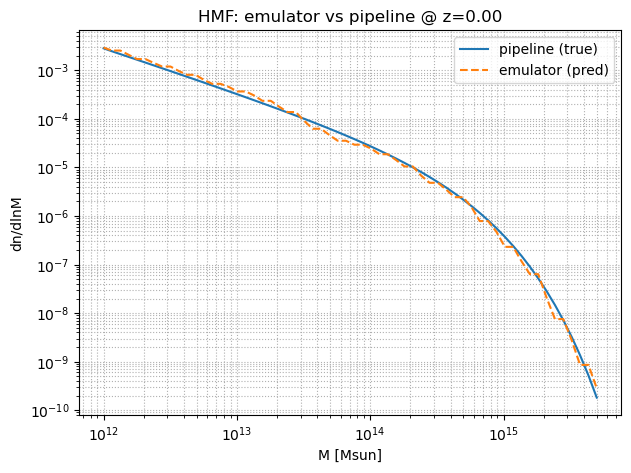

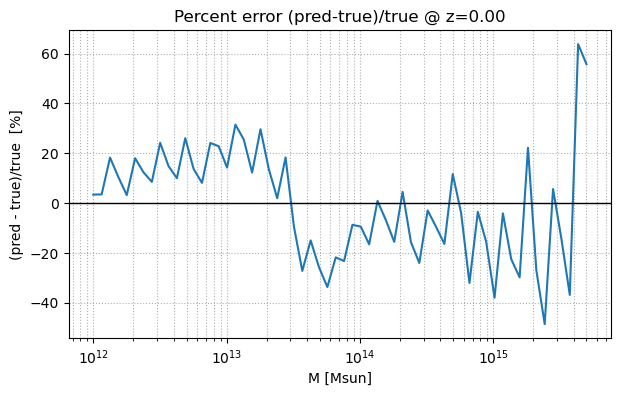

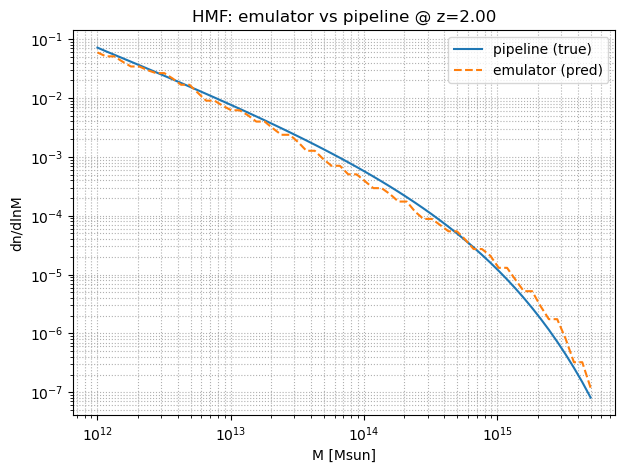

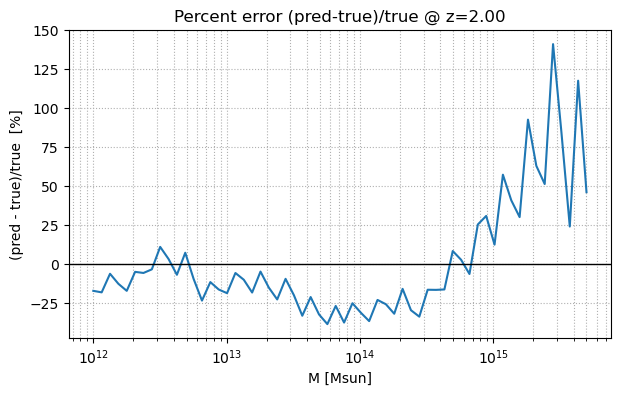

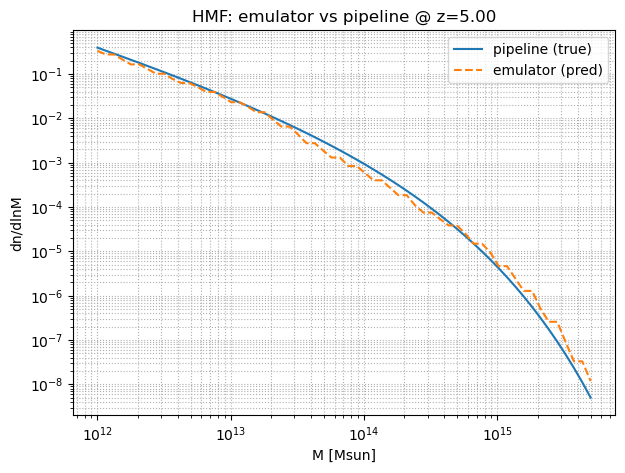

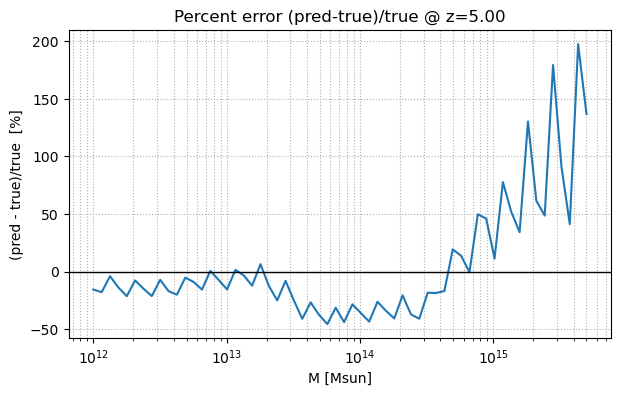

In [ ]:

MODELS_PATH = "lgb_hmf_models.joblib"
META_PATH   = "transform_meta.json"

models = joblib.load(MODELS_PATH)           
meta   = json.load(open(META_PATH))        
feat_cols = meta["feat_cols"]
ranges    = meta["ranges"]
eps       = float(meta["eps"])


def _minmax(x, lo, hi):
    return (x - lo) / (hi - lo)

def build_feature_frame(cosmo, z_vals, M_vals):
   
    z_vals = np.asarray(z_vals, dtype=float)
    M_vals = np.asarray(M_vals, dtype=float)
    a_vals = 1.0 / (1.0 + z_vals)

    ZZ, MM = np.meshgrid(z_vals, M_vals, indexing="ij")
    AA = 1.0 / (1.0 + ZZ)
    log10M = np.log10(MM)

    df = pd.DataFrame({
        "a": AA.ravel(),
        "log10M": log10M.ravel()
    })

    for k,(lo,hi) in ranges.items():
        df[f"{k}_mm"] = _minmax(cosmo[k], lo, hi)

    df = df[feat_cols].astype(np.float64)
    return df

def emulator_predict_log10HMF(cosmo, z_vals, M_vals):
    X = build_feature_frame(cosmo, z_vals, M_vals).to_numpy()
    # mean predictions fold
    preds = np.mean([m.predict(X, num_iteration=m.best_iteration) for m in models], axis=0)
    # reshape (len(z), len(M))
    return preds.reshape(len(z_vals), len(M_vals))

def emulator_predict_HMF(cosmo, z_vals, M_vals):
    y_log = emulator_predict_log10HMF(cosmo, z_vals, M_vals)
    hmf = np.maximum(10.0**y_log - eps, 0.0)
    return hmf

def pipeline_hmf(cosmo, z, M_vals, baryon_effect=True):
    hmf_vals, sigma_vals, sigma8 = full_pipeline_hmf(
        As=cosmo["As"], Om=cosmo["Om"], Ob=cosmo["Ob"],
        h=cosmo["h"], ns=cosmo["ns"], w0=cosmo["w0"], wa=cosmo["wa"],
        A_SN1=cosmo["A_SN1"], A_SN2=cosmo["A_SN2"],
        A_AGN1=cosmo["A_AGN1"], A_AGN2=cosmo["A_AGN2"],
        z=z, M_vals=M_vals, baryon_effect=baryon_effect
    )
    return np.asarray(hmf_vals, dtype=float)


def compare_one_cosmo(cosmo, z_vals, M_vals, baryon_effect=True, make_plots=True):
    
    z_vals = np.asarray(z_vals, dtype=float)
    M_vals = np.asarray(M_vals, dtype=float)

    # Emulator
    hmf_pred = emulator_predict_HMF(cosmo, z_vals, M_vals)  # shape (Z, M)

    # Pipeline
    hmf_true = np.vstack([
        pipeline_hmf(cosmo, z, M_vals, baryon_effect=baryon_effect)
        for z in z_vals
    ])

    # Metrics
    log_true = np.log10(np.clip(hmf_true, a_min=eps, a_max=None))
    log_pred = np.log10(np.clip(hmf_pred, a_min=eps, a_max=None))
    rmse_log = np.sqrt(np.mean((log_true - log_pred)**2))

    # 2)  100 * (pred - true) / true
    den = np.clip(hmf_true, a_min=eps, a_max=None)
    pct = 100.0 * (hmf_pred - den) / den
    median_pct = float(np.median(pct))                 
    p90_abs_pct = float(np.percentile(np.abs(pct), 90))
    p99_abs_pct = float(np.percentile(np.abs(pct), 99))

    metrics = {
        "RMSE_log10HMF": rmse_log,
        "Median_pct_error_(signed)": median_pct,
        "P90_abs_pct_error": p90_abs_pct,
        "P99_abs_pct_error": p99_abs_pct
    }
    print("Metrics:", metrics)

    if make_plots:
        # plot 3 redshifts
        idx = np.round(np.linspace(0, len(z_vals)-1, min(3, len(z_vals)))).astype(int)
        for i in idx:
            z = z_vals[i]
            # HMF
            plt.figure(figsize=(7,5))
            plt.title(f"HMF: emulator vs pipeline @ z={z:.2f}")
            plt.loglog(M_vals, hmf_true[i], label="pipeline (true)")
            plt.loglog(M_vals, hmf_pred[i], ls="--", label="emulator (pred)")
            plt.xlabel("M [Msun]")
            plt.ylabel("dn/dlnM")
            plt.legend()
            plt.grid(True, which="both", ls=":")
            plt.show()

            # % d'écart
            plt.figure(figsize=(7,4))
            plt.title(f"Percent error (pred-true)/true @ z={z:.2f}")
            plt.semilogx(M_vals, pct[i])
            plt.axhline(0.0, lw=1, color='k')
            plt.xlabel("M [Msun]")
            plt.ylabel("(pred - true)/true  [%]")
            plt.grid(True, which="both", ls=":")
            plt.show()

    return metrics, hmf_pred, hmf_true



if __name__ == "__main__":
   
    cosmo = dict(
        As=3.05, Om=0.3, Ob=0.05, h=0.7, ns=0.965,
        w0=-1.0, wa=0.0,
        A_SN1=2.0, A_SN2=2.0, A_AGN1=2.0, A_AGN2=2.0
    )
    z_vals = np.linspace(0, 5, 6)                 
    M_vals = np.logspace(12, np.log10(5e15), 60)  

    compare_one_cosmo(cosmo, z_vals, M_vals, baryon_effect=True, make_plots=True)


### XGBoost_optimize

In [ ]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor

 
cosmo_cols = ["As", "ns", "Om", "Ob", "w0", "wa", "A_SN1", "A_SN2", "A_AGN1", "A_AGN2"]


feature_cols = cosmo_cols + ["Mass", "Z"]   # Z = redshift (z)
target_col = "HMF"

X = df[feature_cols].copy()
y = df[target_col].copy()


def safe_log10(x, eps=1e-30):
    return np.log10(np.clip(x, a_min=eps, a_max=None))

def inv_log10(x):
    return np.power(10.0, x)

preprocess = ColumnTransformer(
    transformers=[
        # log10 for Mass
        ("log_mass", FunctionTransformer(safe_log10), ["Mass"]),
        # scale for cosmology + Z
        ("scale_cosmo_z", StandardScaler(), cosmo_cols + ["Z"]),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

xgb = XGBRegressor(
    n_estimators=800,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    n_jobs=-1,
    tree_method="hist",   
    random_state=42
)

reg = TransformedTargetRegressor(
    regressor=xgb,
    func=safe_log10,      # y' = log10(HMF)
    inverse_func=inv_log10
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", reg)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("== Metrics on original HMF ==")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.6g}")
print(f"RMSE: {rmse(y_test, y_pred):.6g}")
print(f"R^2 : {r2_score(y_test, y_pred):.5f}")

y_test_log = safe_log10(y_test.values)
y_pred_log = safe_log10(np.clip(y_pred, 1e-30, None))
print("\n== Metrics in log10(HMF) space (relative quality) ==")
print(f"MAE_log : {mean_absolute_error(y_test_log, y_pred_log):.6g}")
print(f"RMSE_log: {rmse(y_test_log, y_pred_log):.6g}")
print(f"R^2_log : {r2_score(y_test_log, y_pred_log):.5f}")


== Metrics on original HMF ==
MAE : 0.00381303
RMSE: 0.0190401
R^2 : 0.93872

== Metrics in log10(HMF) space (relative quality) ==
MAE_log : 0.179291
RMSE_log: 0.381991
R^2_log : 0.99767


In [10]:
from joblib import dump, load

dump(pipe, "hmf_model.joblib")
print("Saved model to hmf_model.joblib")


Saved model to hmf_model.joblib


z=2.565
Params: {'As': 3.182315839836465, 'ns': 0.9264678312081792, 'Om': 0.14020294827259794, 'Ob': 0.01926866593530173, 'w0': -1.1944689024323318, 'wa': 0.31196530060233546, 'A_SN1': 4.615252848599998, 'A_SN2': 1.383470948240834, 'A_AGN1': 4.098038191747343, 'A_AGN2': 4.448115031159305}
Ratio median: 0.146 | 5–95%: [0.005, 0.904]


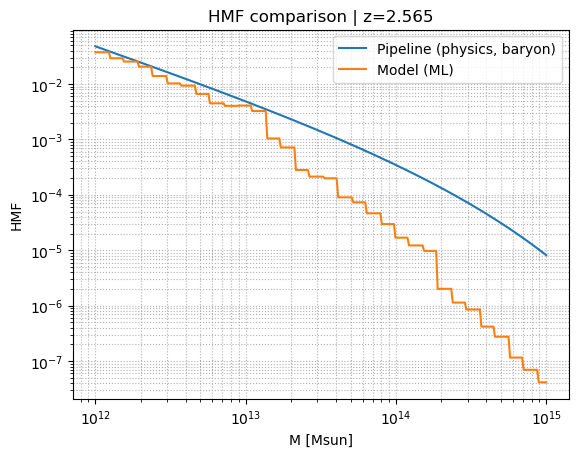

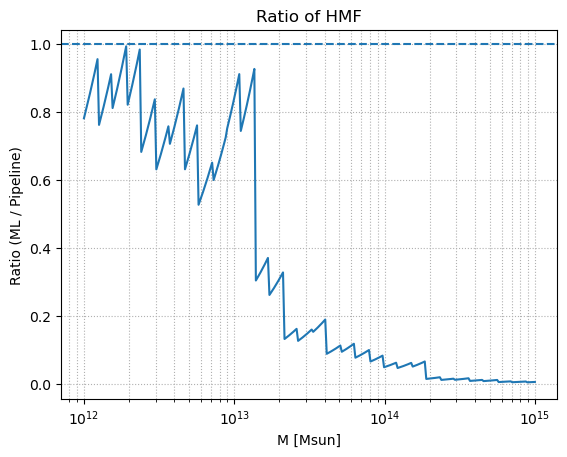

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from symbolic_pofk.pk_to_hmf import full_pipeline_hmf


# df = pd.read_parquet("dataset.parquet")
pipe = load("hmf_model.joblib")


feature_cols = list(pipe.named_steps["prep"].feature_names_in_)


# --- Mass range: 1e12 -> 5e15 ---
M_vals = np.logspace(12, 15, 300)

# --- Sample params aléatoire in range min-max dataset ---
rng = np.random.default_rng(123)

def sample_range(col):
    return float(rng.uniform(df[col].min(), df[col].max()))

params = {c: sample_range(c) for c in feature_cols if c not in ("Mass","Z","z")}
z = sample_range("Z") if "Z" in feature_cols else sample_range("z")

# --- HMF from pipeline (with baryon) ---
h_val = params["h"] if "h" in params else float(df["h"].iloc[0])
hmf_pipe, sigma_vals, sigma8 = full_pipeline_hmf(
    As=params["As"], Om=params["Om"], Ob=params["Ob"], h=h_val, ns=params["ns"],
    w0=params["w0"], wa=params["wa"],
    A_SN1=params.get("A_SN1", 1.0), A_SN2=params.get("A_SN2", 1.0),
    A_AGN1=params.get("A_AGN1", 1.0), A_AGN2=params.get("A_AGN2", 1.0),
    z=z, M_vals=M_vals, baryon_effect=True
)

# Build features 
data_dict = {}
for col in feature_cols:
    if col.lower() == "mass":
        data_dict[col] = M_vals.astype(float)
    elif col in ("Z","z"):
        data_dict[col] = np.full_like(M_vals, float(z), dtype=float)
    else:
        data_dict[col] = np.full_like(M_vals, float(params[col]), dtype=float)

X_grid_df = pd.DataFrame(data_dict, columns=feature_cols)

# --- Predict by model ML ---
hmf_ml = pipe.predict(X_grid_df)

# --- Ratio + plot ---
eps = 1e-30
ratio = hmf_ml / np.clip(hmf_pipe, eps, None)

print(f"z={z:.3f}")
print("Params:", {k: float(params[k]) for k in params})
print(f"Ratio median: {np.median(ratio):.3f} | 5–95%: [{np.percentile(ratio,5):.3f}, {np.percentile(ratio,95):.3f}]")

plt.figure()
plt.loglog(M_vals, hmf_pipe, label="Pipeline (physics, baryon)")
plt.loglog(M_vals, hmf_ml,   label="Model (ML)")
plt.xlabel("M [Msun]"); plt.ylabel("HMF")
plt.title(f"HMF comparison | z={z:.3f}"); plt.grid(True, which="both", ls=":"); plt.legend()

plt.figure()
plt.semilogx(M_vals, ratio); plt.axhline(1.0, ls="--")
plt.xlabel("M [Msun]"); plt.ylabel("Ratio (ML / Pipeline)")
plt.title("Ratio of HMF"); plt.grid(True, which="both", ls=":")

plt.show()


In [15]:
import joblib

torch.save(model.state_dict(), "hmf_emulator.pt")
joblib.dump(scaler, "hmf_input_scaler.pkl")

['hmf_input_scaler.pkl']